Histogram-based Gradient Boosting Regression Tree.

This estimator is much faster than GradientBoostingRegressor for big datasets (n_samples >= 10 000).

This estimator has native support for missing values (NaNs). During training, the tree grower learns at each split point whether samples with missing values should go to the left or right child, based on the potential gain. When predicting, samples with missing values are assigned to the left or right child consequently. If no missing values were encountered for a given feature during training, then samples with missing values are mapped to whichever child has the most samples.

source [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor)

These fast estimators first bin the input samples X into integer-valued bins (typically 256 bins) which tremendously reduces the number of splitting points to consider, and allows the algorithm to leverage integer-based data structures (histograms) instead of relying on sorted continuous values when building the trees. The API of these estimators is slightly different, and some of the features from

more [here](https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_normal = pd.read_csv('./data/normal_training.csv')

In [3]:
test_faulty = pd.read_csv('./data/faulty_testing.csv')

In [4]:
import numpy as np
import sklearn.decomposition
import sklearn.preprocessing

# Preparing the Data

In [5]:
df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]

In [6]:
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

In [7]:
df_test = train_normal[(train_normal.simulationRun>5)&(train_normal.simulationRun<10)].iloc[:,3:]

# Model HGBRR

In [8]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [9]:
class ModelEnsembleRegressors():

    def spe(self, y, y_pred): 
        return (y-y_pred)**2
        
    def train(self, df_train):

        self.mu_train = df_train.mean(axis=0)
        self.std_train = df_train.std(axis=0)
        
        self.models = {}
        spe_df = pd.DataFrame()
        
        self.to_predict_test = []
        
        for col in df_train.columns:
            
            model = HistGradientBoostingRegressor()
            tr_x = sklearn.preprocessing.scale(df_train.drop([col],axis=1))
            tr_y = sklearn.preprocessing.scale(df_train[col])
        
            model.fit(X=tr_x, y=tr_y)
            
            tr_y_pred = model.predict(X=tr_x)
            
            self.models[col] = model
                                    
            spe_df[col] = self.spe(tr_y, tr_y_pred)
            
            self.to_predict_test.append(col)           
                        
        return np.mean(spe_df, axis=1)
    
    def test(self, df_test):

        spe_df = pd.DataFrame()
        
        for col in self.to_predict_test:
            ts_x = np.array((df_test.drop([col],axis=1)-self.mu_train.drop([col]))/self.std_train.drop([col]))
            ts_y = np.array((df_test[col]-self.mu_train[col])/self.std_train[col])
            ts_y_pred = self.models[col].predict(ts_x)
            spe_df[col] = self.spe(ts_y, ts_y_pred)
                
        return np.mean(spe_df, axis=1)

## Noise Filtering 

In [10]:
def filter_noise_ma (df, WS = 100,reduction = False):

    import copy
    
    new_df = copy.deepcopy(df)

    for column in df:
        new_df[column] = new_df[column].rolling(WS).mean()

    if reduction:
        return new_df.drop(df.index[:WS])[::WS]
    else:
        return new_df.drop(df.index[:WS])

## Training the Data

In [11]:
models = {'HGBR': ModelEnsembleRegressors()}
detection_limits = {}

for name, model in models.items():
    
    spe_train = model.train(df_train)
    spe_validation = model.test(df_validation)
    spe_test = model.test(df_test)
    
    detection_limits[name] = np.percentile(spe_validation, 99.99)

## Testig the Data

HGBR    52.41875
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
HGBR,99.25,98.0,0.0,10.875,23.875,100.0,100.0,97.25,0.0,5.25,25.125,96.375,89.625,99.75,0.0,7.25,73.0,92.0,0.0,30.75


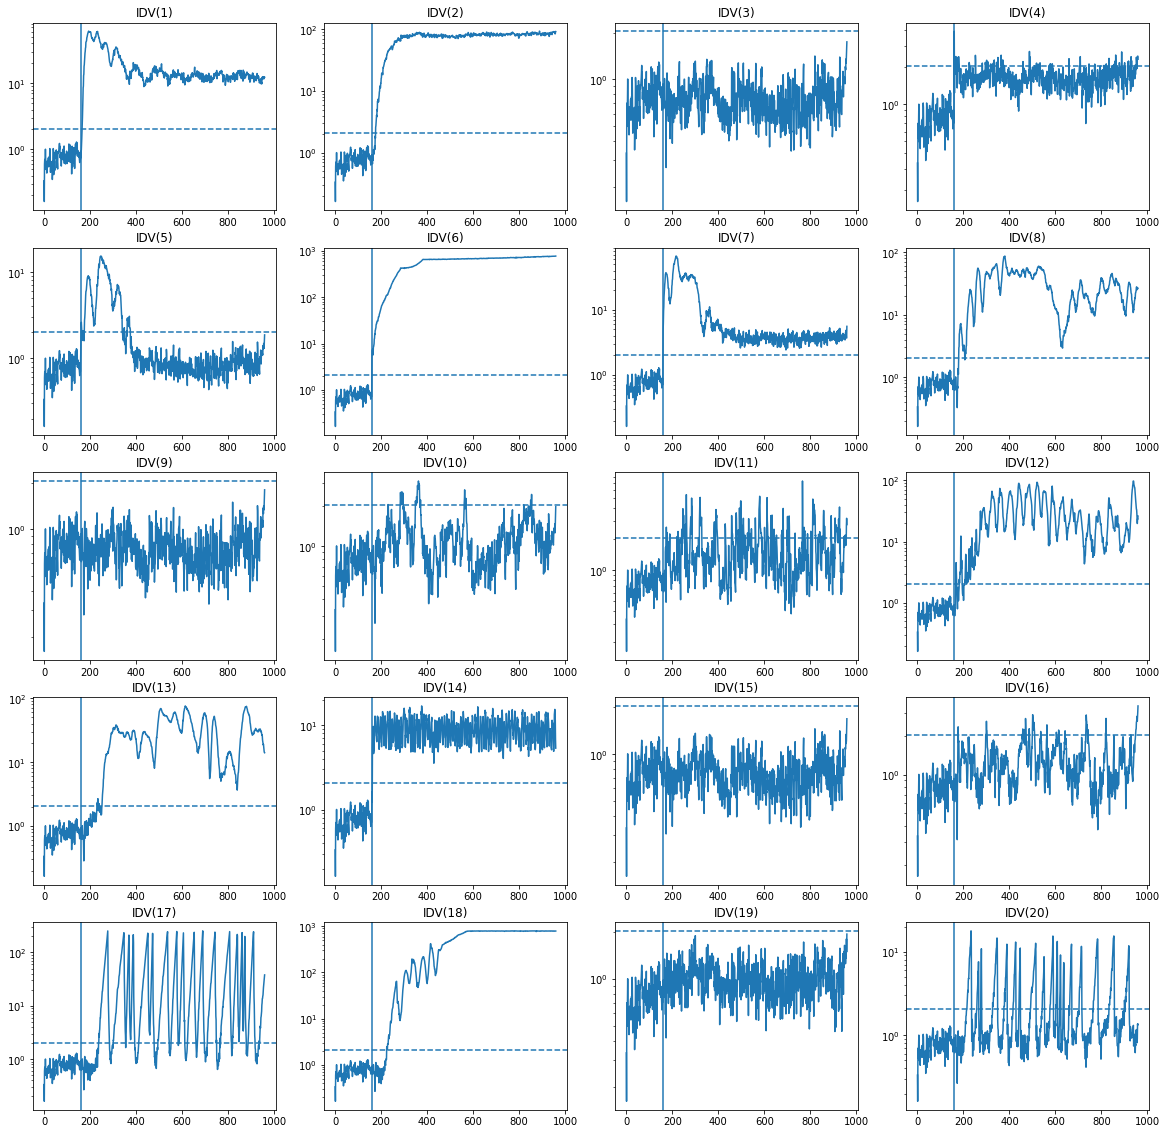

In [12]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []

    for i in range(20):

        df_test = test_faulty[(test_faulty.faultNumber==i+1) & (test_faulty.simulationRun==1)].iloc[:,3:]

        spe_test.append(model.test(df_test))

        fault_occurrence = len(spe_test[i])//6

        fdr.append(np.mean(spe_test[i][fault_occurrence:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(np.arange(len(spe_test[i])), spe_test[i], color = color)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean()) # average of the detection error for every type of disturbance   
100*fdr_df.T

## Filter Noise

WS_10     55.71875
WS_50     58.85625
WS_100    59.08750
dtype: float64


,IDV(1),IDV(2),IDV(3),IDV(4),IDV(5),IDV(6),IDV(7),IDV(8),IDV(9),IDV(10),IDV(11),IDV(12),IDV(13),IDV(14),IDV(15),IDV(16),IDV(17),IDV(18),IDV(19),IDV(20)
WS_10,98.875,98.000,0.0,99.625,28.000,99.750,99.625,97.125,0.0,5.75,68.250,97.875,94.125,10.0,0.0,3.125,85.375,92.500,0.125,36.250
WS_50,98.250,96.625,0.0,98.875,97.625,99.000,99.250,95.125,0.0,2.50,67.875,84.750,93.375,0.0,0.0,0.000,89.625,90.875,0.000,63.375
WS_100,98.000,95.750,0.0,98.500,96.750,98.875,99.000,93.625,0.0,0.00,55.250,83.000,92.125,0.0,0.0,0.000,89.625,90.125,0.000,91.125


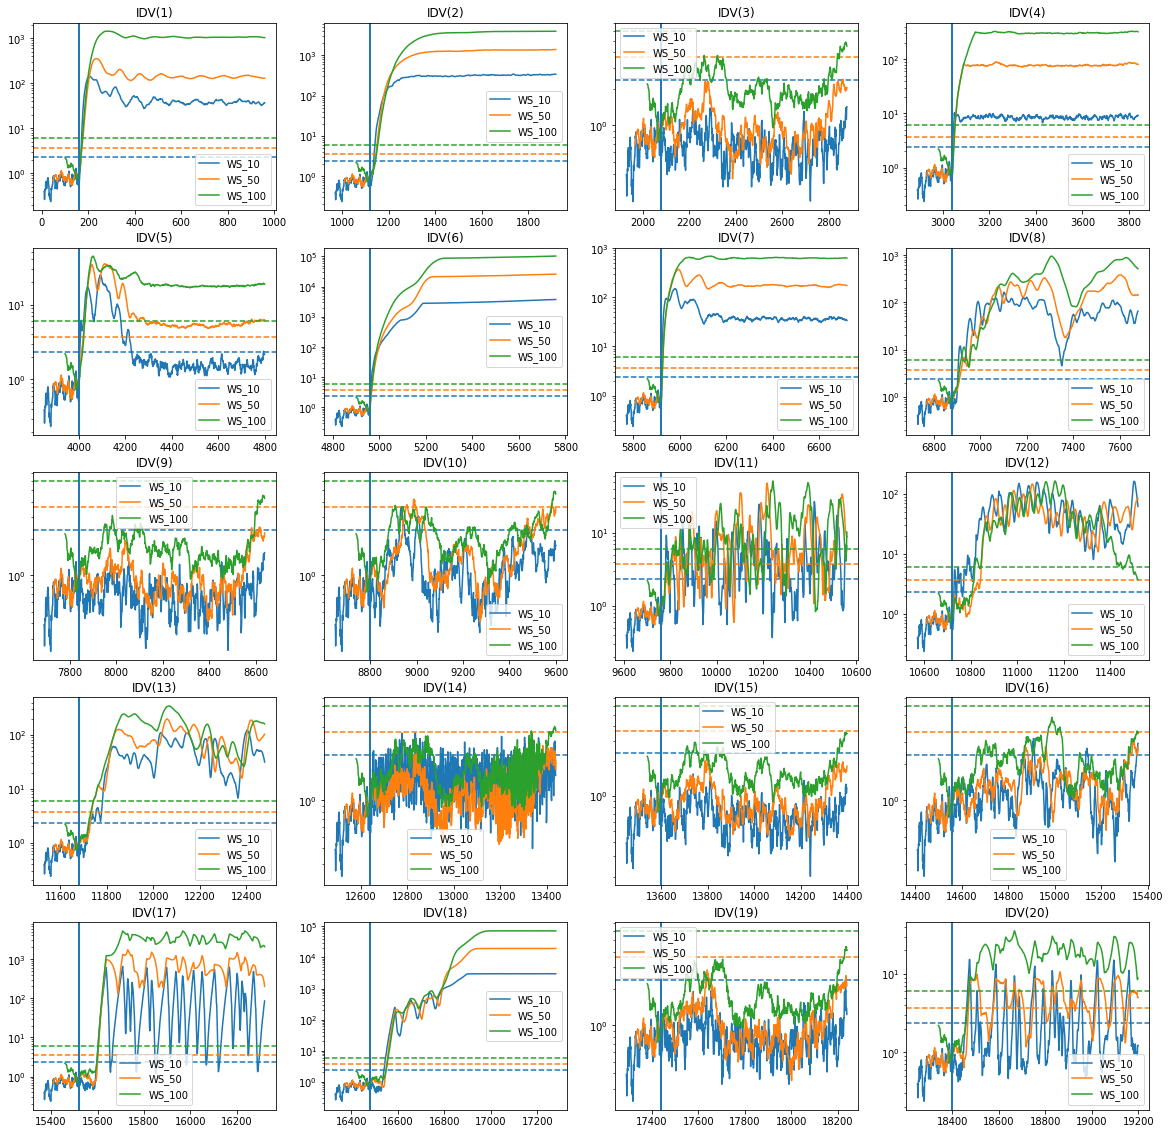

In [13]:
fig, ax = plt.subplots(5,4, figsize = (20, 20))

df_train = train_normal[train_normal.simulationRun==1].iloc[:,3:]
df_validation = train_normal[(train_normal.simulationRun>1)&(train_normal.simulationRun<5)].iloc[:,3:]

models = {'WS_10': ModelEnsembleRegressors(), 'WS_50': ModelEnsembleRegressors(), 'WS_100': ModelEnsembleRegressors()}
WS = {'WS_10': 10, 'WS_50': 50, 'WS_100': 100}

detection_limits = {}

fdr_df = pd.DataFrame(index=[f'IDV({i})' for i in range(1,21)])

for name, model in models.items():

    spe_test = []
    fdr = []
    
    _ = model.train(filter_noise_ma(df_train,WS[name]))
    spe_validation = model.test(filter_noise_ma(df_validation, WS[name]))
    detection_limits[name] = np.percentile(spe_validation, 99.99)

    for i in range(20):
        
        df_test = filter_noise_ma(test_faulty[(test_faulty.faultNumber==i+1) & 
                                                 (test_faulty.simulationRun==1)].iloc[:,3:], WS[name])

        spe_test.append(model.test(df_test))

        fault_occurrence = df_test.index[0]-WS[name]+160

        fdr.append(np.mean(spe_test[i][160-WS[name]:]>detection_limits[name]))

        color = next(ax.ravel()[i]._get_lines.prop_cycler)['color']
        ax.ravel()[i].plot(df_test.index, spe_test[i], color = color, label=name)
        ax.ravel()[i].axhline(detection_limits[name], ls='--', color = color)
        ax.ravel()[i].axvline(fault_occurrence)#, color = color)
        ax.ravel()[i].set_title(f'IDV({i+1})')
        ax.ravel()[i].set_yscale('log')
        ax.ravel()[i].legend()
        
    fdr_df[name] = fdr
    
print(100*fdr_df.mean())
100*fdr_df.T